In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the project files
# project folder, e.g. 'time series metric learning'
FOLDERNAME = 'time series metric learning'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/time series metric learning


In [2]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

     |████████████████████████████████| 112kB 5.6MB/s 
     |████████████████████████████████| 89.4MB 32kB/s 


In [3]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, utils
import torch.optim as optim
import torch.nn.functional as F
from dataset import TimeSeriesDataset, BalancedBatchSampler
from data_utils import load_project_dataset, visualize_timeseries
from data_transformation import ToTensor, Normalize
import torch.nn as nn
from sklearn.manifold import TSNE
from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from torch.optim import lr_scheduler


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    cuda=True
else:
    device = torch.device('cpu')
    cuda=False

print('using device:', device)

using device: cuda


In [5]:
fname="./dataset/project_dataset.csv"
label_multi='Label_multi'
label_binary='Label_binary'
data, labels = load_project_dataset(fname,label_multi)

print("data.shape: ", data.shape)
print("labels.shape: ", labels.shape)

data.shape:  (2997, 4, 1, 1007)
labels.shape:  (2997,)


In [6]:
dataset = TimeSeriesDataset(data = data, train=True, labels=labels)

#split the dataset in train/val/test
#ratio: 80/10/10
train_size=2400
test_size=300
val_size=297

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

print(" train_set: ",train_dataset.dataset.dataset[train_dataset.indices].shape)
print(" valid_set: ",valid_dataset.dataset.dataset[valid_dataset.indices].shape)
print(" test_set: ",test_dataset.dataset.dataset[test_dataset.indices].shape)

 train_set:  (2400, 4, 1, 1007)
 valid_set:  (297, 4, 1, 1007)
 test_set:  (300, 4, 1, 1007)


In [7]:
#compute statistichs on the training set
mean_train=()
std_train=()
dim=4

for i in range (0,dim):
  mean=np.mean(train_dataset.dataset.dataset[train_dataset.indices][:,i,:])
  std=np.std(train_dataset.dataset.dataset[train_dataset.indices][:,i,:])
  mean_train += (mean, )
  std_train += (std, )

print("per dimension(4) mean_train: ",mean_train)
print("per dimension(4) std_train: ",std_train)

per dimension(4) mean_train:  (-0.9656184755742291, 1.8640277207405862, -8.635173844629257, 2.7714679327589424)
per dimension(4) std_train:  (1.018343467391944, 1.2064804488295344, 0.4882609459407678, 7.821591405368547)


In [10]:
#define data transformation: ToTensor -> Normalize
composed_transf = transforms.Compose([
                                    ToTensor(), #transform data and labels into tensors
                                    Normalize(mean_train, std_train),  #normalize each dimension
                                    ])


transformed_train_dataset = TimeSeriesDataset(data = train_dataset.dataset.dataset[train_dataset.indices], 
                                              labels = train_dataset.dataset.labels[train_dataset.indices], 
                                              transform = composed_transf, train=True)

transformed_valid_dataset = TimeSeriesDataset(data = valid_dataset.dataset.dataset[valid_dataset.indices], 
                                              labels = valid_dataset.dataset.labels[valid_dataset.indices], 
                                              transform = composed_transf, train=False)

transformed_test_dataset = TimeSeriesDataset(data = test_dataset.dataset.dataset[test_dataset.indices], 
                                              labels = test_dataset.dataset.labels[test_dataset.indices], 
                                              transform = composed_transf, train=False)


batch_size=40

dataloader_train = DataLoader(transformed_train_dataset, batch_size, shuffle=True)
dataloader_valid = DataLoader(transformed_valid_dataset, batch_size, shuffle=True)
dataloader_test= DataLoader(transformed_test_dataset, batch_size, shuffle=True)

In [21]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv1d(4, 64, 3,stride=1,padding=1),
                                     nn.ReLU(),
                                     nn.MaxPool1d(2),
                                     nn.Conv1d(64, 64, 3,stride=1,padding=1),
                                     nn.BatchNorm1d(64), 
                                     nn.ReLU(),
                                     nn.MaxPool1d(4),)

        self.fc = nn.Sequential(nn.Linear(8000, 256),  
                                nn.BatchNorm1d(256),                                                   
                                nn.ReLU(),
                                nn.Dropout(0.1),  
                                nn.Linear(256, 128),)

    def forward(self, x):
        x=  x.float()
        x = flatten2(x)
        x = self.convnet(x)
        x = flatten1(x)
        x = self.fc(x)
        x = F.normalize(x, p=2, dim=1)
        return x

    def get_embedding(self, x):
        return self.forward(x)


class ClassificationNet(nn.Module):
    def __init__(self, embedding_net, n_classes):
        super(ClassificationNet, self).__init__()
        self.embedding_net = embedding_net
        self.n_classes = n_classes
        self.nonlinear = nn.ReLU()
        self.fc1 = nn.Linear(128, n_classes)

    def forward(self, x):
        output = self.embedding_net(x)
        output = self.nonlinear(output)
        output = self.fc1(output)
        return output

    def get_embedding(self, x):
        return self.nonlinear(self.embedding_net(x))



def flatten1(x):
  N = x.shape[0] # read in N, C, H, W
  return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def flatten2(x):
  N = x.shape[0] # read in N, C, H, W
  C = x.shape[1]
  HW = x.shape[2]*x.shape[3]
  return x.view((N,C,HW))  # "flatten" the  H * W values into a single vector per image


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test_valid(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels=torch.reshape(train_labels, (-1,))
    test_labels=torch.reshape(test_labels, (-1,))
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                test_labels,
                                                train_labels,
                                                False)
    print("NMI: ",accuracies["NMI"])
    print("MaP: ",accuracies["mean_average_precision"])

def test_train(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels=torch.reshape(train_labels, (-1,))
    test_labels=torch.reshape(test_labels, (-1,))
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(test_embeddings, 
                                                train_embeddings,
                                                test_labels,
                                                train_labels,
                                                True)
    print("NMI: ",accuracies["NMI"])
    print("MaP: ",accuracies["mean_average_precision"])


def train(model, optimizer, epochs):
    """
    Train a model using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        #scheduler.step()
        for i_batch, (data, labels) in enumerate(dataloader_train):
            model.train()  # put model to training mode
            data, labels = data.to(device), labels.to(device)
            
            scores = model(data)
            loss = F.cross_entropy(scores, labels)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
  
            loss_history.append(loss.item())
            if i_batch % 100 == 0:
                print('Iteration %d, loss = %.4f' % (i_batch, loss.item()))
        
        val_acc=check_accuracy(dataloader_valid, model)
        train_acc=check_accuracy(dataloader_train, model)

        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        
        print("(Epoch %d / %d) train acc: %f; val_acc: %f" % (e, epochs, train_acc, val_acc))
        scheduler.step(loss)
  

def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for i_batch, (data, labels) in enumerate(loader):
            data, labels = data.to(device), labels.to(device)
            scores = model(data)
            _, preds = scores.max(1)
            num_correct += (preds == labels).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return acc


colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#17becf']
classes = ["0 (OK)","1 (SO SO)","2 (PRE-WARNING)","3 (ALARM)"]
#classes = ["0 (OK)","1 (ALARM)"]

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

In [22]:
val_acc_history=[]
loss_history=[]
train_acc_history=[]


embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=4)
optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.85)

train(model, optimizer,150)

Iteration 0, loss = 1.4012
(Epoch 0 / 150) train acc: 0.590833; val_acc: 0.585859
Iteration 0, loss = 1.2385
(Epoch 1 / 150) train acc: 0.654167; val_acc: 0.646465
Iteration 0, loss = 1.1732
(Epoch 2 / 150) train acc: 0.677500; val_acc: 0.683502
Iteration 0, loss = 1.1889
(Epoch 3 / 150) train acc: 0.702917; val_acc: 0.690236
Iteration 0, loss = 1.1291
(Epoch 4 / 150) train acc: 0.697500; val_acc: 0.717172
Iteration 0, loss = 1.1093
(Epoch 5 / 150) train acc: 0.710417; val_acc: 0.700337
Iteration 0, loss = 1.0489
(Epoch 6 / 150) train acc: 0.718333; val_acc: 0.720539
Iteration 0, loss = 1.0617
(Epoch 7 / 150) train acc: 0.737500; val_acc: 0.713805
Iteration 0, loss = 0.9897
(Epoch 8 / 150) train acc: 0.742917; val_acc: 0.723906
Iteration 0, loss = 0.9465
(Epoch 9 / 150) train acc: 0.748750; val_acc: 0.727273
Iteration 0, loss = 0.9857
(Epoch 10 / 150) train acc: 0.756250; val_acc: 0.760943
Iteration 0, loss = 0.9756
(Epoch 11 / 150) train acc: 0.747500; val_acc: 0.757576
Iteration 0, l

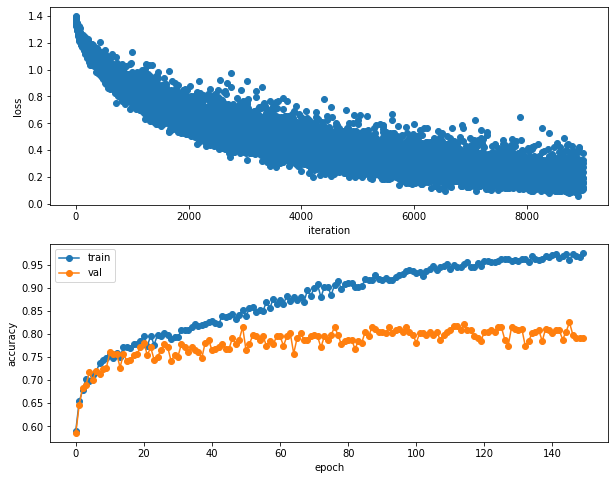

In [23]:
plt.subplot(2, 1, 1)
plt.plot(loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history, '-o')
plt.plot(val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [24]:
print("accuracy test set:",check_accuracy(dataloader_test, model))

accuracy test set: 0.7033333333333334


100%|██████████| 10/10 [00:01<00:00,  6.94it/s]


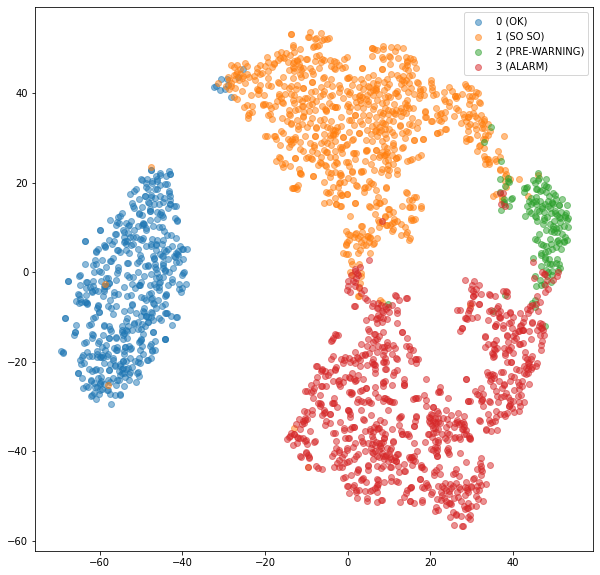

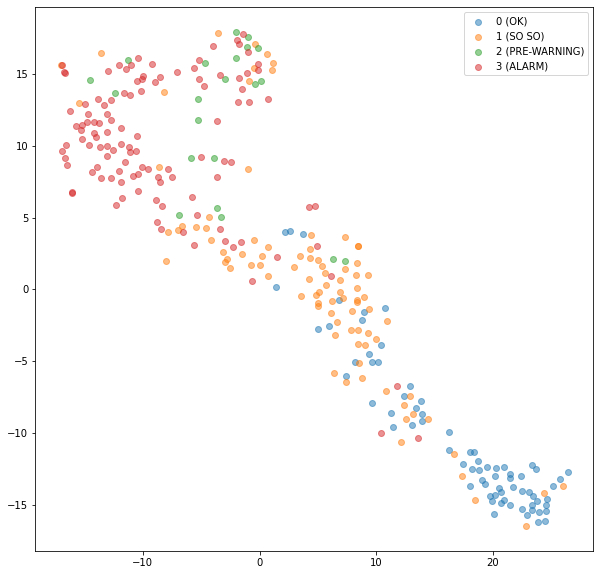

In [25]:
tsne = TSNE(n_components=2)
train_embeddings, train_labels = get_all_embeddings(transformed_train_dataset, model.embedding_net)
test_embeddings, test_labels = get_all_embeddings(transformed_test_dataset, model.embedding_net)

train_embeddings=train_embeddings.cpu().numpy()
train_labels=train_labels.cpu().numpy()

test_embeddings=test_embeddings.cpu().numpy()
test_labels=test_labels.cpu().numpy()

train_embeddings_2d = tsne.fit_transform(train_embeddings)
plot_embeddings(train_embeddings_2d, train_labels)

test_embeddings_2d = tsne.fit_transform(test_embeddings)
plot_embeddings(test_embeddings_2d, test_labels)

In [26]:
from sklearn.neighbors import KNeighborsClassifier

for k in [1,3,5,10,12,20]:
  neigh = KNeighborsClassifier(n_neighbors=k, p=2)
  neigh.fit(train_embeddings, train_labels)

  predict=neigh.predict(test_embeddings)

  score=neigh.score(test_embeddings, test_labels)

  print('K = {}   Score: {:.4f}'.format(k, score))

K = 1   Score: 0.7100
K = 3   Score: 0.7033
K = 5   Score: 0.7167
K = 10   Score: 0.7033
K = 12   Score: 0.7067
K = 20   Score: 0.7100


In [27]:
test_valid(transformed_train_dataset, transformed_test_dataset, model,  AccuracyCalculator(include = ("mean_average_precision","NMI",), k=3))

100%|██████████| 10/10 [00:01<00:00,  6.90it/s]


Computing accuracy
NMI:  0.39191743529986545
MaP:  0.7152777777777778
